In [1]:
# IMPORT LIBS
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, StandardScaler, PowerTransformer
from sklearn.metrics import recall_score, precision_score, f1_score, average_precision_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, \
    precision_recall_curve, PrecisionRecallDisplay
from sklearn.pipeline import Pipeline

from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
import seaborn as sns
import pandas as pd
import numpy as np
import copy
import optuna
from optuna.integration import XGBoostPruningCallback
import os
import matplotlib.pyplot as plt
from scipy.special import expit
import shap
import random

/Users/furkangul/Documents/rpaa-recruiting-case-furkan/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:

TARGET_VAR = "is_default"
# Ordinal categorical are categorical values for which the order is meaningful, for example
# for cat_number_accounts: '3' > '2' > '1'
ORDINAL_CAT_FEATS = ["cat_number_accounts", "cat_number_loans_accounts", \
    'cat_number_client_calls_from_ING']
# I will treat postal codes as nominal features because the ordering of the codes doesn't 
# provide any meaningful information about the relationships between the areas they represent.
NOMINAL_CAT_FEATS = ["loan_reason", "gender", "religion", "employment", \
    "postal_code"]
NUMERICAL_FEATS = ['age', 'relationship_length', \
        'average_salary', 'average_current_acc_balance', 'average_monthly_balance']

NUMERICAL_SKEWED_FEATS = ["requested_amount", "payback_amount", "installment", \
    'number_client_calls_to_ING', 'average_saving_account_balance', 'average_credit_card_balance', \
        'average_debt_to_income_ratio']

N_FOLDS = 5
CV_RESULT_DIR = "../xgboost_cv_results"
SEED = 12345

In [3]:
def seed_everything(seed: int):
    """
    Sets the seed for generating random numbers. This is used for reproducibility in experiments.

    Args:
        seed (int): The seed value to be set for generating random numbers.
    """
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

seed_everything(SEED)

In our case missing a positive case (false negative) can much more cause to the loss than incorrectly diagnosing a default loan (false positive). false negatives are most crucial ones to detect. Where our model states there is no default, but actually there is a default. In my perspective, this will cause a lot of loss to the bank.

So, recall for default category in label is more important than precision and my main evaluation metric.

If the customers who are predicted as default, will not have a default loan in reality, then this can be a loss to the bank. If these two are considered equally weighted loss to the bank, I will consider AUC precision-recall as main evaluation metric. This is the average_precision_score in sklearn (see https://sinyi-chou.github.io/python-sklearn-precision-recall/)

# Generate a baseline model: Logistics Regression

#### TRAIN-TEST SPLIT

In [4]:
df = pd.read_csv("../processed_data/final_df.csv")
df

,loan_reason,requested_amount,payback_amount,installment,cat_number_accounts,cat_number_loans_accounts,gender,religion,employment,postal_code,...,cat_number_client_calls_from_ING,age,relationship_length,average_salary,average_current_acc_balance,average_saving_account_balance,average_credit_card_balance,average_monthly_balance,average_debt_to_income_ratio,is_default
0,Car,5000.0,6349.92,264.58,1.0,0.0,M,C,Unemployed,20.0,...,0.0,31.0,3.0,2446.784000,-584.426000,81.126667,809.798667,-251.649667,0.331706,0.0
1,Financial,10000.0,13800.00,230.00,3.0,0.0,M,U,Public Sector,40.0,...,5.0,42.0,3.0,NaN,560.767895,2124.778421,NaN,1342.773158,NaN,1.0
2,Housing,15000.0,17250.24,359.38,2.0,0.0,F,J,Self-employed,20.0,...,1.0,26.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0
3,Personal,7000.0,9239.76,128.33,1.0,0.0,M,J,Private Sector,50.0,...,2.0,37.0,3.0,1543.714583,-1155.817083,2489.885833,NaN,667.034375,NaN,0.0
4,Financial,10000.0,13800.24,191.67,1.0,0.0,F,O,Unemployed,30.0,...,0.0,38.0,3.0,3111.351333,-162.762667,1410.700000,NaN,623.968667,NaN,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35985,Car,10000.0,12699.84,264.58,1.0,2.0,M,U,Private Sector,20.0,...,4.0,40.0,2.0,NaN,1746.097143,0.000000,NaN,873.048571,NaN,0.0
35986,Car,4000.0,5080.32,70.56,1.0,1.0,M,U,Private Sector,70.0,...,0.0,38.0,1.0,1527.442353,1550.418235,1444.917059,1761.714706,1497.667647,1.496681,0.0
35987,Car,7000.0,8890.08,370.42,1.0,0.0,F,J,Unemployed,10.0,...,5.0,39.0,3.0,1584.795000,-675.707500,23.578750,NaN,-326.064375,NaN,1.0
35988,Financial,5000.0,6900.00,287.50,1.0,0.0,M,C,Private Sector,20.0,...,0.0,42.0,4.0,NaN,755.230000,2786.745000,NaN,1770.987500,NaN,0.0


In [5]:
X = copy.deepcopy(df)
y = X.pop(TARGET_VAR)  # this removes the column "is_default" from X and puts it into y

# Split 70%-20%-10% for train-val-test since it is not big data over 1 million samples.
X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.1, stratify=y, random_state=SEED)

Check datasets, their shapes, distribution of target across train and test:

In [6]:
X_train

,loan_reason,requested_amount,payback_amount,installment,cat_number_accounts,cat_number_loans_accounts,gender,religion,employment,postal_code,number_client_calls_to_ING,cat_number_client_calls_from_ING,age,relationship_length,average_salary,average_current_acc_balance,average_saving_account_balance,average_credit_card_balance,average_monthly_balance,average_debt_to_income_ratio
19754,Car,12000.0,15240.00,317.50,1.0,0.0,M,C,Unemployed,50.0,0.0,1.0,38.0,2.0,NaN,514.075000,87.290000,NaN,300.682500,NaN
35218,Car,15000.0,19050.00,793.75,1.0,0.0,M,U,Private Sector,30.0,2.0,0.0,26.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN
29019,Car,10000.0,12700.08,352.78,1.0,0.0,F,C,Private Sector,60.0,0.0,1.0,28.0,3.0,NaN,1798.356667,692.896667,NaN,1245.626667,NaN
7379,Car,15000.0,19050.24,396.88,2.0,0.0,M,O,Public Sector,40.0,3.0,2.0,37.0,3.0,1964.064286,1527.827619,3949.467619,23.357143,2738.647619,0.011386
12322,Housing,10000.0,11500.20,191.67,1.0,0.0,M,M,Private Sector,30.0,2.0,1.0,33.0,2.0,1913.672692,3328.116538,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30471,Financial,12000.0,16560.00,345.00,2.0,0.0,F,C,Private Sector,70.0,0.0,5.0,39.0,0.0,NaN,958.346364,0.000000,0.000000,479.173182,NaN
11883,Personal,25000.0,33000.00,550.00,1.0,0.0,M,O,Self-employed,70.0,5.0,5.0,32.0,2.0,1754.150333,-444.522000,2408.538667,NaN,982.008333,NaN
9904,Financial,7000.0,9659.88,268.33,1.0,0.0,F,J,Private Sector,20.0,0.0,0.0,32.0,2.0,3284.708000,2131.533000,1412.993000,NaN,1772.263000,NaN
17483,Housing,10000.0,11500.08,479.17,1.0,0.0,M,C,Unemployed,30.0,0.0,0.0,49.0,0.0,2714.921000,-818.712000,2516.531000,733.695000,848.909500,0.316792


In [7]:
y_train

19754    0.0
35218    0.0
29019    0.0
7379     0.0
12322    0.0
        ... 
30471    1.0
11883    1.0
9904     0.0
17483    0.0
27791    0.0
Name: is_default, Length: 32391, dtype: float64

In [8]:
y_train.value_counts()

is_default
0.0    29560
1.0     2831
Name: count, dtype: int64

In [9]:
y_test.value_counts()

is_default
0.0    3285
1.0     314
Name: count, dtype: int64

In [10]:
# I already checked skewness for numerical features, but let's double check
skewness_threshold = 0.7  
    
# Identify skewed features
skewness = np.abs(X[NUMERICAL_FEATS+NUMERICAL_SKEWED_FEATS].apply(lambda x: x.skew()))
skewed_features = skewness[skewness > skewness_threshold].index
skewed_features

Index(['requested_amount', 'payback_amount', 'installment',
       'number_client_calls_to_ING', 'average_saving_account_balance',
       'average_credit_card_balance', 'average_debt_to_income_ratio'],
      dtype='object')

In [11]:
def get_inference_pipeline(config, model_fnc, is_feats_select=False, num_features_to_keep=5):
    # Build a pipeline with two steps:
    # 1 - A SimpleImputer(strategy="constant") to impute missing values
    # 2 - A OneHotEncoder() or OrdinalEncoder() step to encode the categorical feature
    
    ordinal_cat_encoder = Pipeline(steps=[
        ("imputer", SimpleImputer(strategy="constant", fill_value=0)),
        ("encoder", OrdinalEncoder())])


    nominal_cat_encoder = Pipeline(steps=[
        ("imputer", SimpleImputer(strategy="constant", fill_value="UNKNOWN")),
        ("encoder", OneHotEncoder())])

    numerical_encoder = Pipeline(steps=[
        ("imputer", SimpleImputer(strategy="constant", fill_value=-999)), # -999 represents "UNKNOWN"
        ('scaler', StandardScaler())])
    
    numerical_skewed_encoder = Pipeline(steps=[
        ("imputer", SimpleImputer(strategy="constant", fill_value=-999)), # -999 represents "UNKNOWN"
        ('scaler', PowerTransformer(method='yeo-johnson'))]) # There were no change in recall.

    # Let's put everything together
    encoder = ColumnTransformer(
        transformers=[
            ("ordinal_cat_feats", ordinal_cat_encoder, ORDINAL_CAT_FEATS),
            ("nominal_cat_feats", nominal_cat_encoder, NOMINAL_CAT_FEATS),
            ("numerical_feats", numerical_encoder, NUMERICAL_FEATS),
            ("numerical_skewed_feats", numerical_skewed_encoder, NUMERICAL_SKEWED_FEATS)
        ],
        remainder="drop",  # This drops the columns that we do not transform
    )

    # processed_features = ordinal_cat_feats + nominal_cat_feats + numerical_feats + numerical_skewed_feats

    # Create a model
    model = model_fnc(**config)

    # Use Recursive Feature Elimination (RFE) for feature selection
    # In this example, in default keep the top 5 features
    # Use SelectFromModel for feature selection
    selector = RFE(model, n_features_to_select=num_features_to_keep)


    # Create the inference pipeline. The pipeline can have many steps: 
    # a step called "encoder" applying the ColumnTransformer instance that we saved in the `encoder` variable,
    # and a step called "model" with the model_fnc instance that I just saved in the `model` variable etc.
    if is_feats_select is False:
        pipeline = Pipeline(steps=[("encoder", encoder),
                                   ("model", model)])
    else:    
        pipeline = Pipeline(steps=[("encoder", encoder),
                                   ('feature_selection', selector),
                                   ("model", model)])
    
    return pipeline, encoder

In [12]:
# Create a logistic regression model
config = {"penalty":'l2',
          "solver":'lbfgs',
          "max_iter":1000,
          "random_state": SEED} 

model = LogisticRegression

# Fit a model
pipe, encoder = get_inference_pipeline(config, model, is_feats_select=True, num_features_to_keep=1)
pipe.fit(X_train, y_train)

# Get predicted probabilities
y_pred_proba = pipe.predict_proba(X_test)[:, 1]  # Probabilities of the positive class

threshold = 0.4  # since recall is more critical (minimizing false negatives), u can choose a lower threshold than 0.5. 
y_pred = (y_pred_proba >= threshold).astype(int)

# y_pred = pipe.predict(X_test)

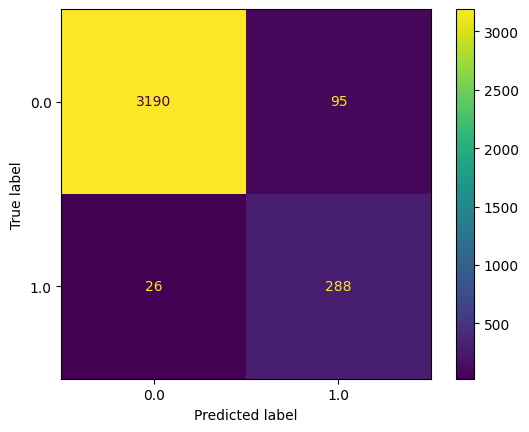

In [13]:
# Calculate confusion matrix and display
cm = confusion_matrix(y_test, y_pred, labels=pipe.classes_)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, \
    display_labels=pipe.classes_)
disp.plot()

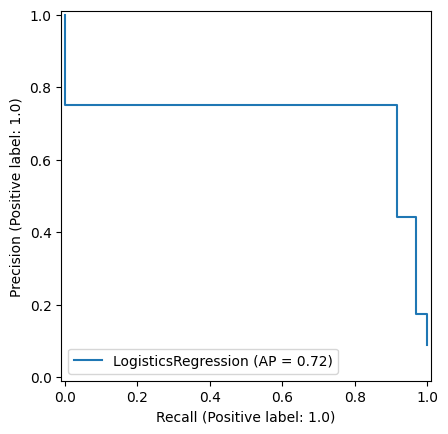

In [14]:
PrecisionRecallDisplay.from_estimator(pipe, X_test, y_test, name="LogisticsRegression")  

In [15]:
# Define classes
classes = pipe.classes_
# class_0_label = classes[0] # It represents 0 where there is no default.
class_1_label = classes[1] # It represents 1 where there is a default.

# Calculate recall for both classes
# recall_class_0 = recall_score(y_test, y_pred, labels=[class_0_label], average=None)
recall_class_1 = recall_score(y_test, y_pred, labels=[class_1_label], average=None)
precision_class_1 = precision_score(y_test, y_pred, labels=[class_1_label], average=None)
auc_pr_class_1 = average_precision_score(y_test, y_pred_proba) # It takes probability instead of thresholded values.
f1_class_1 = f1_score(y_test, y_pred, labels=[class_1_label], average=None)

# print("Recall for Class 0:", round(recall_class_0[0], 3))
print("Recall for Class 1:", round(recall_class_1[0], 3))
print("Precision for Class 1:", round(precision_class_1[0], 3))
print("AUC-PR for Class 1:", round(auc_pr_class_1, 3))
print("F1 for Class 1:", round(f1_class_1[0], 3))

Recall for Class 1: 0.917
Precision for Class 1: 0.752
AUC-PR for Class 1: 0.718
F1 for Class 1: 0.826


##### Check and examine what we found

In [16]:
# Find which features are selected by RFE
support = pipe.named_steps['feature_selection'].support_

# Extract feature names
feature_names=pipe.named_steps['encoder'].get_feature_names_out()

assert len(pipe.named_steps['feature_selection'].support_) == \
    len(pipe.named_steps['encoder'].get_feature_names_out()), "ERROR: TOTAL FEATURE NUMBER IS NOT MATCHED"

rfe_feats = np.array(feature_names)[support]
print(f"Features selected by RFE and used by our model: {rfe_feats.tolist()}")

Features selected by RFE and used by our model: ['ordinal_cat_feats__cat_number_client_calls_from_ING']


In [17]:
# FIND CORRELATION BETWEEN FEATURES AND LABEL
# Use the pipeline to transform the input data
encoded_features = pipe.named_steps['encoder'].transform(X)

# Convert the result to a DataFrame for better visualization
encoded_features_df = pd.DataFrame(encoded_features, columns=feature_names)
encoded_features_df[TARGET_VAR] = y # Add label to df

# Create correlations
correlation_matrix = encoded_features_df.corr()

# Calculate and sort correlation with label
target_correlations = correlation_matrix[TARGET_VAR].sort_values(ascending=False).reset_index()
print(target_correlations)

                                                index  is_default
0                                          is_default    1.000000
1   ordinal_cat_feats__cat_number_client_calls_fro...    0.612413
2            numerical_skewed_feats__requested_amount    0.161861
3              numerical_skewed_feats__payback_amount    0.155068
4                 numerical_skewed_feats__installment    0.121412
5                         nominal_cat_feats__gender_M    0.024361
6                       nominal_cat_feats__religion_U    0.019362
7                 nominal_cat_feats__postal_code_80.0    0.007365
8                  nominal_cat_feats__loan_reason_Car    0.006187
9                 nominal_cat_feats__postal_code_60.0    0.005678
10                nominal_cat_feats__postal_code_10.0    0.003834
11           nominal_cat_feats__loan_reason_Financial    0.003276
12       nominal_cat_feats__employment_Private Sector    0.003215
13       ordinal_cat_feats__cat_number_loans_accounts    0.002196
14        

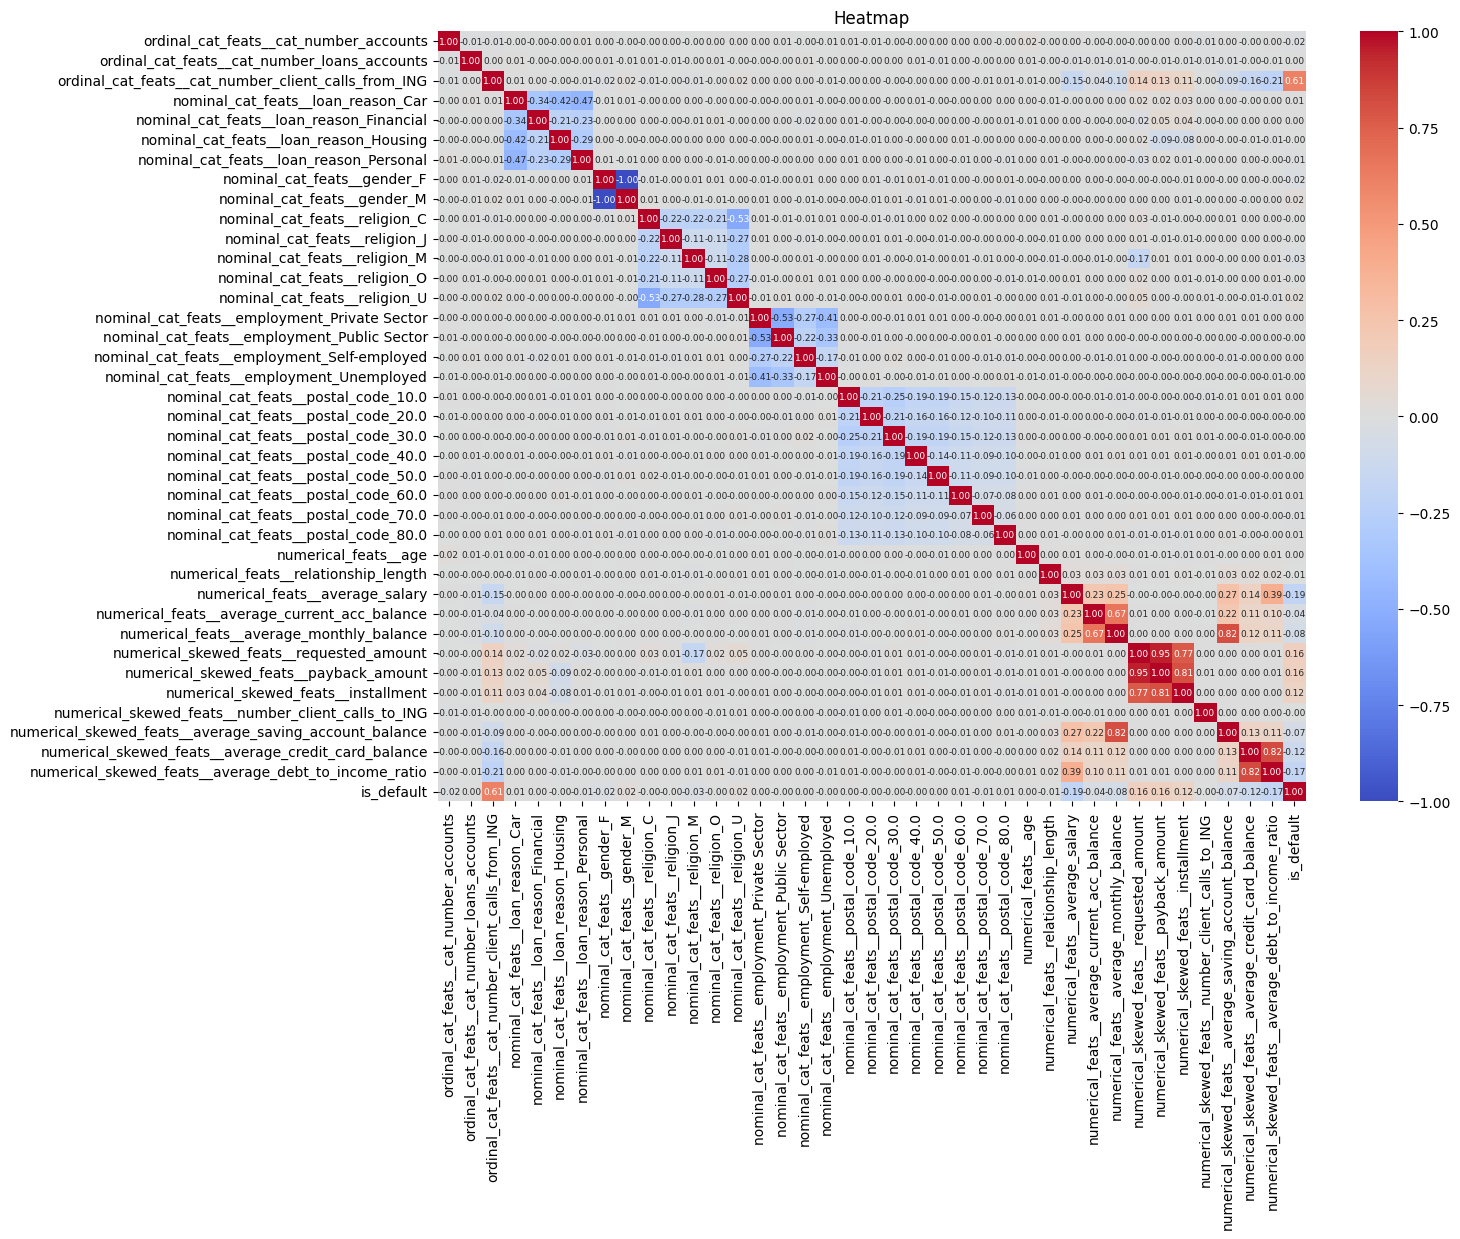

In [18]:
# Plot heatmap
plt.figure(figsize=(14, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", xticklabels=1, annot_kws={"size": 6.5})
plt.xticks(rotation=90)
plt.title('Heatmap')
plt.show()

- So, correlation justifies our logistic regression model using RFE. So, my baseline model is Logistics Regression with just one crucial feature using RFE. It gives 0.917 in recall (using 0.5 threshold) for being default loan at best case. When not using RFE, it gives 0.809 recall. So, stick to using RFE.

- when using threshold of 0.5: recall: 0.917, precision: 0.752, f1: 0.826.
- when using threshold of 0.4: recall: 0.917, precision: 0.752, f1: 0.826.

Both gave the same eval scores for three metrics.

ordinal_cat_feats__cat_number_client_calls_from_ING feature with a positive correlation close to +1 indicate a strong positive relationship with the target variable.

Absolute correlation value of 0.12-0.20 indicates a relatively weak positive linear relationship between the feature and the target variable. A positive correlation suggests that as the feature increases, there is a slight tendency for the target variable to also increase.
The strength of the relationship is considered weak because the correlation coefficient is closer to 0 than to +1.
In practical terms, a correlation of 0.12 is on the lower end of the strength scale. While it does suggest a positive relationship, it's not very strong. The feature might have some influence on the target variable, but the impact is likely not substantial based on the correlation alone. For training xgboost, I will only use them: 
- ordinal_cat_feats__cat_number_client_calls_from_ING, 
- numerical_skewed_feats__requested_amount, 
- numerical_skewed_feats__payback_amount, 
- numerical_skewed_feats__installment,
- numerical_skewed_feats__average_credit_card_balance,
- numerical_skewed_feats__average_debt_to_income_ratio
- numerical_feats__average_salary

#### Explainability of base model

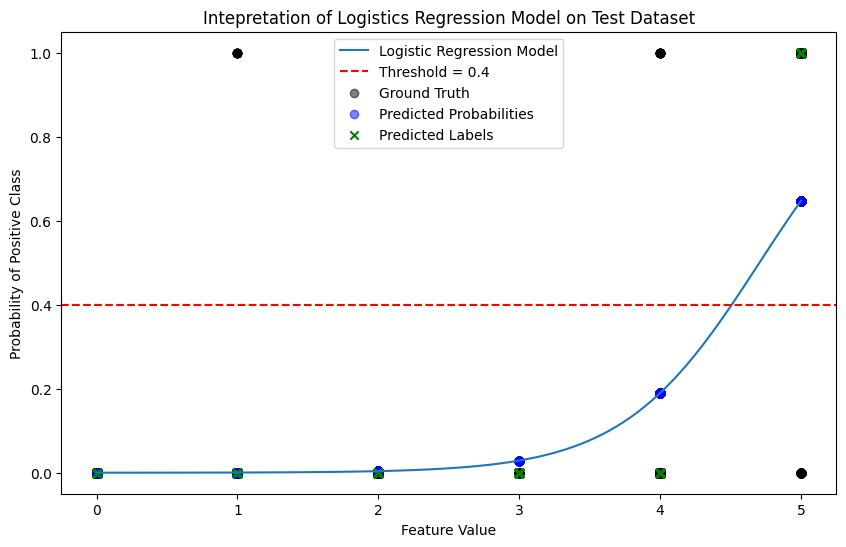

In [19]:
clf = pipe.named_steps['model']
# Generate a range of values from the minimum to the maximum value of the feature in the test set
feature_range = np.linspace(X_test["cat_number_client_calls_from_ING"].min(), \
    X_test["cat_number_client_calls_from_ING"].max(), 100).reshape(-1, 1)

# Predict probabilities for the generated range by MATHEMATICAL FORMULA
y = feature_range * clf.coef_ + clf.intercept_ # AS SIMPLE AS THAT
probabilities = expit(y).ravel() # logistic sigmoid function, is defined as expit(x) = 1/(1+exp(-x)). 
# probabilities = clf.predict_proba(feature_range)[:, 1]

# Plot the logistic regression curve
plt.figure(figsize=(10, 6))
plt.plot(feature_range, probabilities, label='Logistic Regression Model')

# Plot the threshold line
plt.axhline(y=threshold, color='red', linestyle='--', label=f'Threshold = {threshold}')

# Scatter plot of the actual test set points
plt.scatter(X_test["cat_number_client_calls_from_ING"], y_test, color='black', label='Ground Truth', alpha=0.5)

# Scatter plot of the predicted probabilities for the test set
plt.scatter(X_test["cat_number_client_calls_from_ING"], y_pred_proba, color='blue', label='Predicted Probabilities', alpha=0.5)

# Scatter plot of the predicted labels for the test set
plt.scatter(X_test["cat_number_client_calls_from_ING"], y_pred, color='green', label='Predicted Labels', marker='x')
    
# Label the axes
plt.xlabel('Feature Value')
plt.ylabel('Probability of Positive Class')
# Add a legend
plt.legend()
# Add title
plt.title("Intepretation of Logistics Regression Model on Test Dataset")
# Show the plot
plt.show()

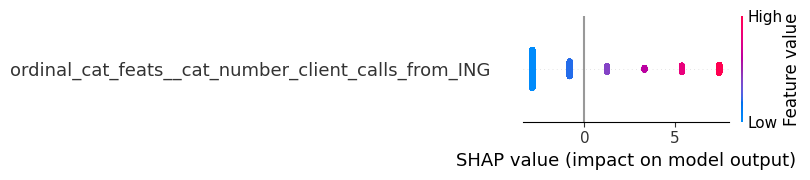

In [20]:
# SHAP analysis
encoder = pipe.named_steps['encoder']
X_train_encoded = encoder.transform(X_train)
X_train_encoded =pd.DataFrame(X_train_encoded[:, support], columns=rfe_feats)


explainer = shap.LinearExplainer(clf, X_train_encoded)
shap_values = explainer.shap_values(X_train_encoded)
# Visualize SHAP summary plot
shap.summary_plot(shap_values, X_train_encoded)

### Train a gradient boosting model: XGBoost

XGBoost (Extreme Gradient Boosting) does not require explicit encoding of categorical features because it inherently handles them during the training process. XGBoost has a mechanism to handle categorical variables directly without the need for one-hot encoding or other preprocessing steps.

In [21]:
df = pd.read_csv("../processed_data/final_df.csv")

CAT_FEATS_TO_CONSIDER = ["cat_number_client_calls_from_ING"]
NUMERICAL_FEATS_TO_CONSIDER = ["requested_amount", "payback_amount", "installment", \
        "average_credit_card_balance", "average_debt_to_income_ratio", "average_salary"]

df[CAT_FEATS_TO_CONSIDER] = df[CAT_FEATS_TO_CONSIDER].astype('category') # The easiest way to pass categorical data into XGBoost

In [22]:
X = copy.deepcopy(df)[CAT_FEATS_TO_CONSIDER + NUMERICAL_FEATS_TO_CONSIDER + [TARGET_VAR]]
y = X.pop(TARGET_VAR)  # this removes the column "is_default" from X and puts it into y

# Split 70%-20%-10% for train-val-test since it is not big data over 1 million samples.
X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.1, stratify=y, random_state=SEED)

- Note that I do not scale numerical features because the tree-based models do not need that since they are less sensitive to the scale of numerical features.

In [23]:
# Specifying xgb config
xgb_config={}
#xgb_config['learning_rate'] = 0.03
xgb_config['objective'] = 'binary:logistic' # Binary target feature
xgb_config['eval_metric']='aucpr' # metric for binary classification: Area under the PR curve
xgb_config['scale_pos_weight'] = y.value_counts()[0] / y.value_counts()[1] # number of neg samples / number of pos samples
xgb_config['random_state'] = SEED
xgb_config['n_estimators'] = 1000

clf = xgb.XGBClassifier(**xgb_config, enable_categorical=True)
clf.fit(X_train, y_train)

# Get predicted probabilities
y_pred_proba = clf.predict_proba(X_test)[:, 1]  # Probabilities of the positive class

threshold = 0.4  # since recall is more critical (minimizing false negatives), u can choose a lower threshold than 0.5. 
y_pred = (y_pred_proba >= threshold).astype(int)

# y_pred = clf.predict(X_test)

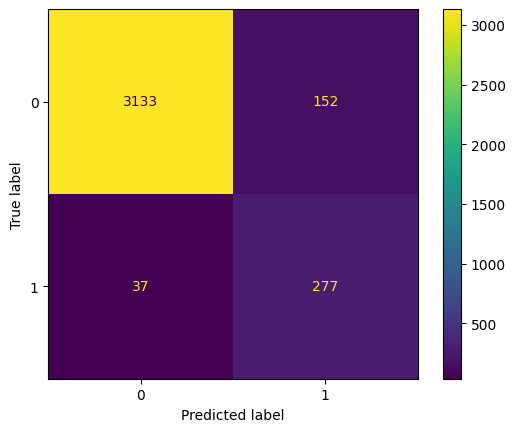

In [24]:
# Calculate confusion matrix and display
cm = confusion_matrix(y_test, y_pred, labels=clf.classes_)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, \
    display_labels=clf.classes_)
disp.plot()

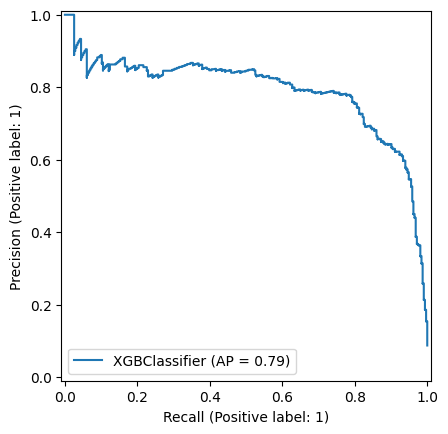

In [25]:
PrecisionRecallDisplay.from_estimator(clf, X_test, y_test)

In [26]:
# Define classes
classes = clf.classes_
# class_0_label = classes[0] # It represents 0 where there is no default.
class_1_label = classes[1] # It represents 1 where there is a default.

# Calculate recall for both classes
# recall_class_0 = recall_score(y_test, y_pred, labels=[class_0_label], average=None)
recall_class_1 = recall_score(y_test, y_pred, labels=[class_1_label], average=None)
precision_class_1 = precision_score(y_test, y_pred, labels=[class_1_label], average=None)
auc_pr_class_1 = average_precision_score(y_test, y_pred_proba) # It takes probability instead of thresholded values.
f1_class_1 = f1_score(y_test, y_pred, labels=[class_1_label], average=None)

# print("Recall for Class 0:", round(recall_class_0[0], 3))
print("Recall for Class 1:", round(recall_class_1[0], 3))
print("Precision for Class 1:", round(precision_class_1[0], 3))
print("AUC-PR for Class 1:", round(auc_pr_class_1, 3))
print("F1 for Class 1:", round(f1_class_1[0], 3))

Recall for Class 1: 0.882
Precision for Class 1: 0.646
AUC-PR for Class 1: 0.791
F1 for Class 1: 0.746


- 0.914 recall is obtained with 7 features without hyperparameter tuning XGBoost model using 0.5 threshold. It is MARGINALLY LESS then my baseline Linear Logistics Regression Model, 0.917. But, 0.698 precision and 0.792 F1 of XGBoost are SMALLER than my baseline: 0.752 precision, 0.826 F1.
- 0.917 recall is obtained with 1 feature ("cat_number_client_calls_from_ING") without hyperparameter tuning XGBoost model using 0.5 threshold. It is SAME as my baseline Linear Logistics Regression Model, 0.917.

- when using threshold of 0.5 -> recall: 0.914, precision: 0.698, f1: 0.792.
- when using threshold of 0.4 -> recall: 0.917, precision: 0.752, f1: 0.826.

##### Model Explainability

In XGBoost, the final prediction is a combination of predictions from all the trees in the ensemble. XGBoost is an ensemble learning algorithm based on the boosting technique. The boosting process involves training multiple weak learners (usually decision trees) sequentially, and each new tree corrects the errors of the previous ones.

For binary classification, each tree in the ensemble predicts a probability for the positive class (class 1).
- The predictions of individual trees are combined through a weighted sum.
- The final prediction for a sample is obtained by summing the predicted probabilities from all the trees.

The XGBoost model has 1000 trees.


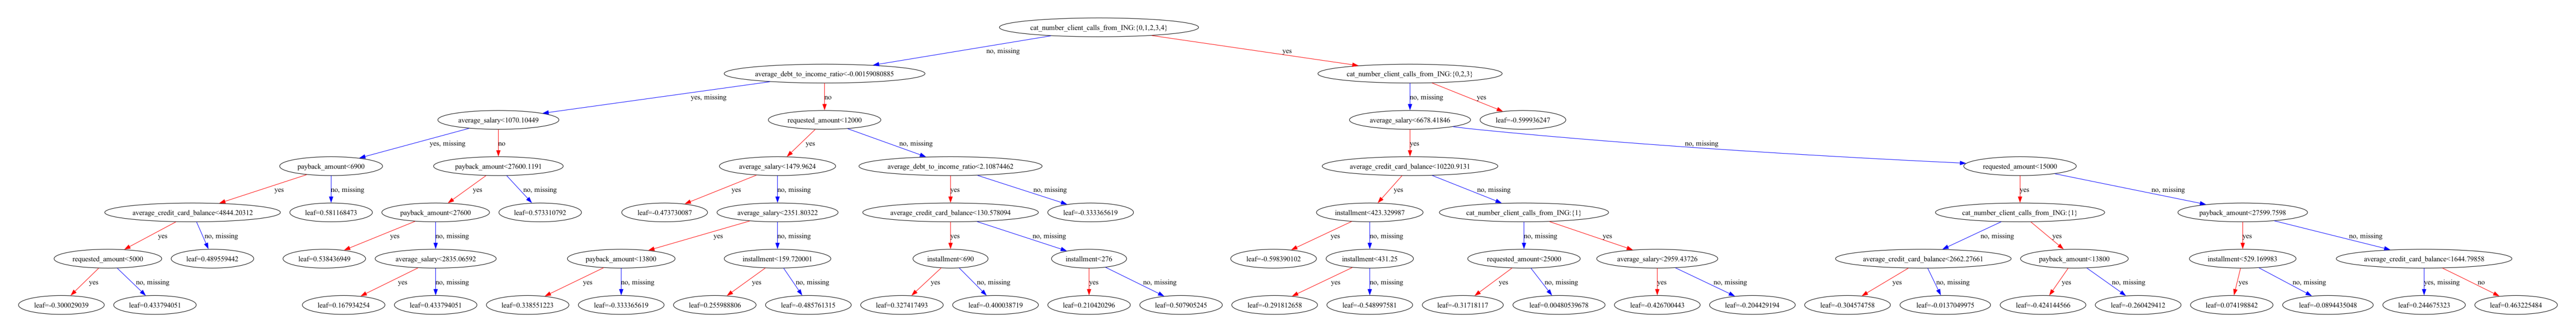

In [27]:
# Get the number of trees (boosting rounds)
num_trees = clf.n_estimators

print(f"The XGBoost model has {num_trees} trees.")

# Specify the index of the tree you want to visualize (e.g., 0 for the first tree)
tree_index = 0

# Set figure size and DPI for better quality
fig, ax = plt.subplots(figsize=(20, 10), dpi=300)

# Plot the specified tree
xgb.plot_tree(clf, num_trees=tree_index, ax=ax)
plt.show()

# plt.savefig('tree_visualization.png', dpi=300)

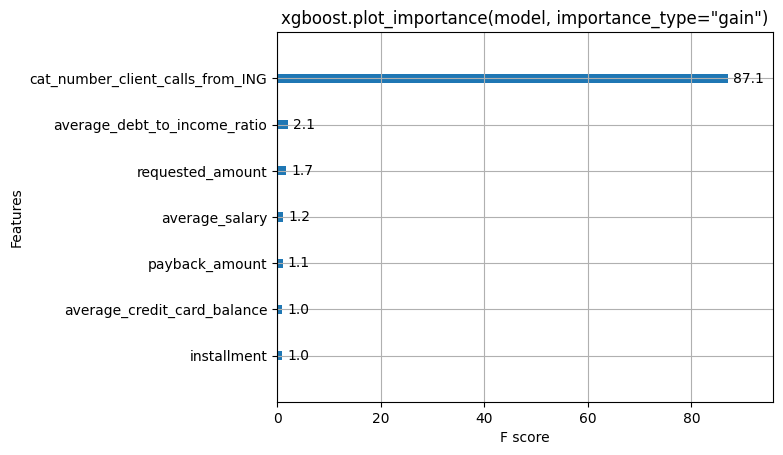

In [28]:
xgb.plot_importance(clf, values_format="{v:.1f}", importance_type="gain") # the average gain of splits which use the feature
plt.title('xgboost.plot_importance(model, importance_type="gain")')
plt.show()

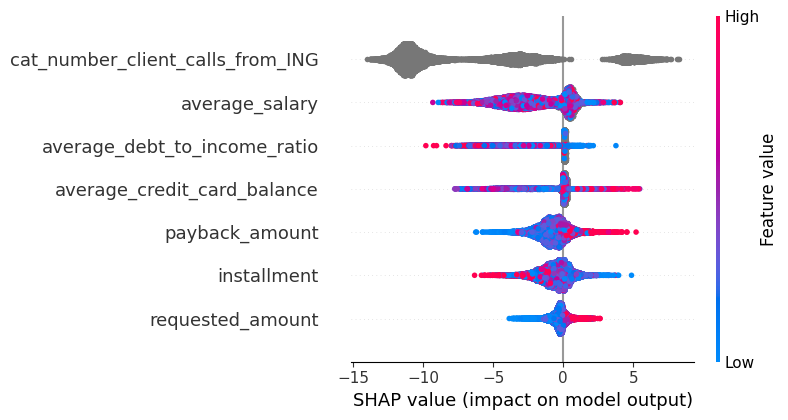

In [29]:
# Get the Booster object from XGBoost
booster = clf.get_booster()

# Get contributions using Booster's predict method with pred_contribs option and make SHAP analysis
shap_values = booster.predict(xgb.DMatrix(X_train, enable_categorical=True), pred_contribs=True)[:, :-1]
# Visualize SHAP summary plot
shap.summary_plot(shap_values, X_train)


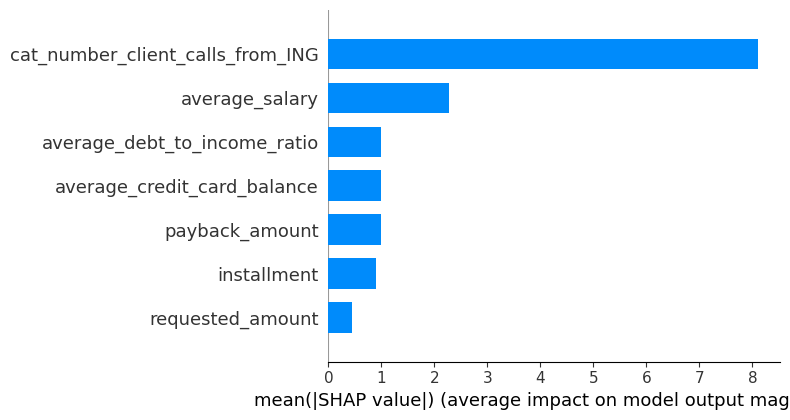

In [30]:
# This takes the average of the SHAP value magnitudes across 
# the dataset and plots it as a simple bar chart.
shap.summary_plot(shap_values, X_train, plot_type="bar")

### Hyperparameter Optimization

In [31]:
def objective(trial, X_train, y_train):
    dtrain = xgb.DMatrix(X_train, label=y_train, enable_categorical=True)
    param = {
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 1),
        "max_depth": trial.suggest_int("max_depth", 3, 12),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 10),
        "subsample": trial.suggest_float("subsample", 0.5, 1),
        "gamma": trial.suggest_int("gamma", 0, 5),
        "lambda": trial.suggest_int("lambda", 1, 10),
        'objective':'binary:logistic',
        'eval_metric':'aucpr',
        'scale_pos_weight':y.value_counts()[0] / y.value_counts()[1],
        'random_state':SEED,
        # "n_estimators": 1000
    }
        
    xgb_cv_results = xgb.cv(
        params=param,
        dtrain=dtrain,
        num_boost_round=1000, # it means n_estimators
        nfold=N_FOLDS,
        stratified=True,
        early_stopping_rounds=100,
        seed=SEED,
        verbose_eval=False,
    )
    
    # Set n_estimators as a trial attribute; Accessible via study.trials_dataframe().
    trial.set_user_attr("n_estimators", len(xgb_cv_results))

    # Save cross-validation results.
    filepath = os.path.join(CV_RESULT_DIR, f"{trial.number}.csv")
    xgb_cv_results.to_csv(filepath, index=False)

    # Extract the best score.
    best_score = xgb_cv_results["test-aucpr-mean"].values[-1]
    return best_score

In [32]:
study = optuna.create_study(direction="maximize", study_name="XGBoost Classifier")
study.optimize(lambda trial: objective(trial, X_train, y_train), n_trials=100, timeout=600) # in second(s)

[I 2024-01-24 19:42:34,359] A new study created in memory with name: XGBoost Classifier
[W 2024-01-24 19:42:36,560] Trial 0 failed with parameters: {'learning_rate': 0.2055359822444658, 'max_depth': 11, 'min_child_weight': 4, 'subsample': 0.7677081409615634, 'gamma': 3, 'lambda': 3} because of the following error: OSError("Cannot save file into a non-existent directory: '../xgboost_cv_results'").
Traceback (most recent call last):
  File "/Users/furkangul/Documents/rpaa-recruiting-case-furkan/.venv/lib/python3.11/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "/var/folders/h7/qvwlww5x1b3dtn1tdg2f4vrc0000gn/T/ipykernel_15783/1076676718.py", line 2, in <lambda>
    study.optimize(lambda trial: objective(trial, X_train, y_train), n_trials=100, timeout=600) # in second(s)
                                 ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/var/folders/h7/qvwlww5x1b3dtn1tdg2f4vrc0000gn/T/ip

OSError: Cannot save file into a non-existent directory: '../xgboost_cv_results'

In [ ]:
print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))
    
print("  Number of estimators: {}".format(trial.user_attrs["n_estimators"]))

In [ ]:
# XGB config with best hparams
xgb_default_config = {
                        'objective':'binary:logistic',
                        'eval_metric':'aucpr',
                        'scale_pos_weight':y.value_counts()[0] / y.value_counts()[1],
                        'random_state':SEED,
                        "n_estimators":1000
                        }
xgb_config = {**xgb_default_config, **study.best_params}

# Model fitting
clf = xgb.XGBClassifier(**xgb_config, enable_categorical=True)
clf.fit(X_train, y_train)

# Get predicted probabilities
y_pred_proba = clf.predict_proba(X_test)[:, 1]  # Probabilities of the positive class

threshold = 0.4  # since recall is more critical (minimizing false negatives), u can choose a lower threshold than 0.5. 
y_pred = (y_pred_proba >= threshold).astype(int)

# y_pred = clf.predict(X_test)

In [ ]:
# Calculate confusion matrix and display
cm = confusion_matrix(y_test, y_pred, labels=clf.classes_)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, \
    display_labels=clf.classes_)
disp.plot()

In [ ]:
PrecisionRecallDisplay.from_estimator(clf, X_test, y_test)

In [ ]:
# Define classes
classes = clf.classes_
# class_0_label = classes[0] # It represents 0 where there is no default.
class_1_label = classes[1] # It represents 1 where there is a default.

# Calculate recall for both classes
# recall_class_0 = recall_score(y_test, y_pred, labels=[class_0_label], average=None)
recall_class_1 = recall_score(y_test, y_pred, labels=[class_1_label], average=None)
precision_class_1 = precision_score(y_test, y_pred, labels=[class_1_label], average=None)
auc_pr_class_1 = average_precision_score(y_test, y_pred_proba) # It takes probability instead of thresholded values.
f1_class_1 = f1_score(y_test, y_pred, labels=[class_1_label], average=None)

# print("Recall for Class 0:", round(recall_class_0[0], 3))
print("Recall for Class 1:", round(recall_class_1[0], 3))
print("Precision for Class 1:", round(precision_class_1[0], 3))
print("AUC-PR for Class 1:", round(auc_pr_class_1, 3))
print("F1 for Class 1:", round(f1_class_1[0], 3))

- 0.936 recall is obtained with 7 features after hyperparameter tuning XGBoost model using 0.5 threshold. It is LARGER then my baseline Linear Logistics Regression Model, 0.917. But, 0.67 precision and 0.781 F1 of XGBoost are SMALLER than my baseline: 0.752 precision, 0.826 F1.

- when using threshold of 0.5: recall: 0.936, precision: 0.67, f1: 0.781.
- when using threshold of 0.4: recall: 0.955, precision: 0.621, f1: 0.753.

Both gave the same eval scores for three metrics.

#### Model Explainability

In [ ]:
# Get the number of trees (boosting rounds)
num_trees = clf.n_estimators

print(f"The XGBoost model has {num_trees} trees.")

# Specify the index of the tree you want to visualize (e.g., 0 for the first tree)
tree_index = 0

# Set figure size and DPI for better quality
fig, ax = plt.subplots(figsize=(20, 10), dpi=300)

# Plot the specified tree
xgb.plot_tree(clf, num_trees=tree_index, ax=ax)
plt.show()

# plt.savefig('tree_visualization.png', dpi=300)

In [ ]:
xgb.plot_importance(clf, values_format="{v:.1f}", importance_type="gain") # the average gain of splits which use the feature
plt.title('xgboost.plot_importance(model, importance_type="gain")')
plt.show()

In [ ]:
# Get the Booster object from XGBoost
booster = clf.get_booster()

# Get contributions using Booster's predict method with pred_contribs option and make SHAP analysis
shap_values = booster.predict(xgb.DMatrix(X_train, enable_categorical=True), pred_contribs=True)[:, :-1]
# Visualize SHAP summary plot
shap.summary_plot(shap_values, X_train)

In [ ]:
# This takes the average of the SHAP value magnitudes across 
# the dataset and plots it as a simple bar chart.
shap.summary_plot(shap_values, X_train, plot_type="bar")

## MODEL SELECTION

WHAT ABOUT THE CUSTOMERS WHOM THE BANK WILL NOT LEND MONEY TO DUE TO THE MODEL, BUT WHO WOULD PAY WITHOUT DEFAULTING. IN MY OPINION, THEY SHOULD BE ALSO CONSIDERED LOST. SINCE THIS ASSUMPTION IS NOT STATED IN README DOCUMENT, I WILL NOT CONSIDER THIS FACT FOR MY ANALYSIS.

- If I don't consider that fact, I would continue with tuned XGBoost model since it has the highest recall of 0.955.
- If I consider that fact (assuming both cases have the same loss to the bank), I would continue with baseline Logistics Regression model since it has the highest F1 of 0.826.

In terms of interpretability, our baseline is more simpler and better.

When the both performance and interpretability are considered, I will stick with baseline logistics regression model.